In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
#os.environ['TORCH_LOGS'] = "+dynamo"
#os.environ['TORCHDYNAMO_VERBOSE'] = "1"
import warnings
# Suppress the symbolic shapes warning
# warnings.filterwarnings("ignore", message="xindex is not in var_ranges")

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from torch.utils.data import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image
from vae_equivariant_architecture import D4_Equivariant_VAE
from PIL import Image

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy
import gc

torch.cuda.empty_cache()
gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [2]:
# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [3]:
class TiledImageDataset(Dataset):
    def __init__(self, data_dir, image_ids, transform=None):
        self.data_dir = data_dir
        self.image_ids = image_ids
        self.transform = transform
        self.image_paths = []
        
        # Collect all image paths for the given image IDs
        for image_id in image_ids:
            image_folder = os.path.join(data_dir, image_id)
            for img_name in os.listdir(image_folder):
                self.image_paths.append(os.path.join(image_folder, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img


In [4]:
# Assuming `image_ids` is a list of all folder names (IDs of the original images)
data_dir = '../UBC-Ocean-Data/Autoencoder'
image_ids = os.listdir(data_dir)  # List of all original image IDs

# Split image IDs
train_ids, temp_ids = train_test_split(image_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=2/3, random_state=42)  # 10% validation, 20% test

# Create datasets
train_dataset = TiledImageDataset(data_dir, train_ids, transform=transform)
val_dataset = TiledImageDataset(data_dir, val_ids, transform=transform)
test_dataset = TiledImageDataset(data_dir, test_ids, transform=transform)

batch_size=2**6

In [ ]:
# Get 10% of training data for each epoch
def get_subset_sampler(dataset, seed, percentage=0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    np.random.seed(seed + 42)
    np.random.shuffle(indices)
    
    split = int(np.ceil(percentage * dataset_size))
    train_indices = indices[:split]
    
    return SubsetRandomSampler(train_indices)

Training Epoch 1/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

/media/max/f7de66f7-119c-4593-a8ab-02f75c636771/Max/experimentos-ubc-ocean-pathology/test_VAE_Equivariant/d4_equivariant.py:94: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  out = F.conv2d(x, transformed_filters, padding=self.padding, bias=expanded_bias, stride=self.stride)


Validation Epoch 1/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0182, Learning Rate: 0.001


Training Epoch 2/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 2/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 2, Training Loss: 0.0146, Validation Loss: 0.0129, Learning Rate: 0.001


Training Epoch 3/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 3/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 3, Training Loss: 0.0127, Validation Loss: 0.0119, Learning Rate: 0.001


Training Epoch 4/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 4/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 4, Training Loss: 0.0113, Validation Loss: 0.0117, Learning Rate: 0.001


Training Epoch 5/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 5/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 5, Training Loss: 0.0112, Validation Loss: 0.0116, Learning Rate: 0.001


Training Epoch 6/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 6/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 6, Training Loss: 0.0111, Validation Loss: 0.0115, Learning Rate: 0.001


Training Epoch 7/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 7/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 7, Training Loss: 0.0111, Validation Loss: 0.0115, Learning Rate: 0.001


Training Epoch 8/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 8/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 8, Training Loss: 0.0111, Validation Loss: 0.0115, Learning Rate: 0.001


Training Epoch 9/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 9/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 9, Training Loss: 0.0111, Validation Loss: 0.0114, Learning Rate: 0.001


Training Epoch 10/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 10/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 10, Training Loss: 0.0111, Validation Loss: 0.0114, Learning Rate: 0.001


Training Epoch 11/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 11/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 11, Training Loss: 0.0111, Validation Loss: 0.0114, Learning Rate: 0.001


Training Epoch 12/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 12/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 12, Training Loss: 0.0110, Validation Loss: 0.0113, Learning Rate: 0.001


Training Epoch 13/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 13/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 13, Training Loss: 0.0110, Validation Loss: 0.0113, Learning Rate: 0.001


Training Epoch 14/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 14/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 14, Training Loss: 0.0110, Validation Loss: 0.0113, Learning Rate: 0.001


Training Epoch 15/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 15/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 15, Training Loss: 0.0110, Validation Loss: 0.0113, Learning Rate: 0.001


Training Epoch 16/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 16/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 16, Training Loss: 0.0110, Validation Loss: 0.0113, Learning Rate: 0.001


Training Epoch 17/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 17/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 17, Training Loss: 0.0110, Validation Loss: 0.0113, Learning Rate: 0.001


Training Epoch 18/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 18/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 18, Training Loss: 0.0109, Validation Loss: 0.0113, Learning Rate: 0.001


Training Epoch 19/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 19/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 19, Training Loss: 0.0109, Validation Loss: 0.0112, Learning Rate: 0.001


Training Epoch 20/20:   0%|          | 0/2162 [00:00<?, ?batch/s]

Validation Epoch 20/20:   0%|          | 0/1320 [00:00<?, ?batch/s]

Epoch 20, Training Loss: 0.0109, Validation Loss: 0.0112, Learning Rate: 0.001


Validation:   0%|          | 0/3081 [00:00<?, ?batch/s]

Test Loss: 0.0106


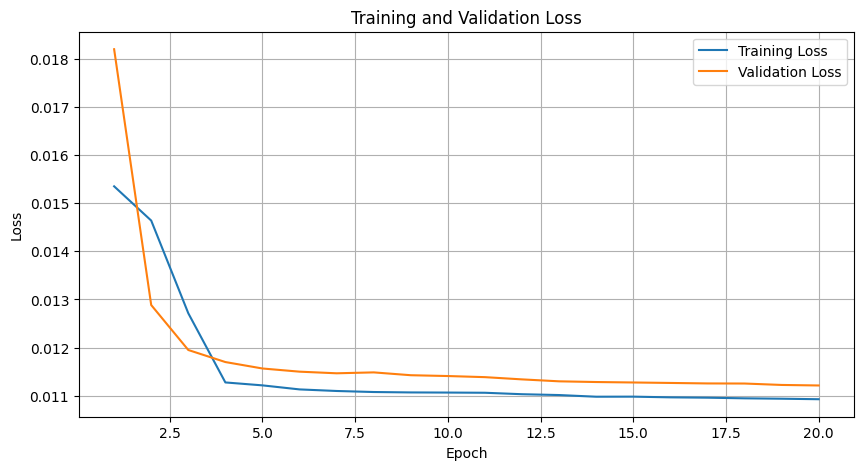

4275

In [6]:
# Model, optimizer, and compilation
latent_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = D4_Equivariant_VAE(latent_dim)
compiled_vae = vae.to(device)
#compiled_vae = torch.compile(vae,fullgraph=True,dynamic=False).to(device)
#compiled_vae.load_state_dict(torch.load('epochs/epoch_10/vae_weights_epoch_10.pth',weights_only=True))

optimizer = optim.AdamW(compiled_vae.parameters(), lr=0.001, weight_decay=1e-5)

# Create the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', 
    factor=0.9, 
    patience=1,
    cooldown=1,)

num_epochs = 20
train_losses = []
val_losses = []

# Select and save 24 images from the test set (ensure to keep this consistent across epochs)
n=24
fixed_batch = next(iter(DataLoader(test_dataset, batch_size=n, shuffle=True)))
for i in range(n):
    save_image(fixed_batch[i],fp=f'epochs/example_imgs/img_{i}.png')

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/vae_experiment')
# Log original images to TensorBoard
writer.add_images('Original Images', fixed_batch, 0)


# sample 10% of data per epoch and log everything
best_val_loss = float('inf')
for epoch in range(num_epochs):
    sampler = get_subset_sampler(train_dataset, seed=epoch, percentage=0.2)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, pin_memory=True)
    #accumulated_gradients = {name: torch.zeros_like(param) for name, param in compiled_vae.named_parameters()}
    compiled_vae.train()
    train_loss = 0
    num_samples=0
    # Use tqdm to create a progress bar for the training loop
    with tqdm(total=len(train_loader), desc=f'Training Epoch {epoch + 1}/{num_epochs}', unit='batch', position=0, leave=False) as pbar:
        for batch in train_loader:
            batch = batch.to(device,non_blocking=True)
            assert not torch.isnan(batch).any(), f"Input contains NaN at epoch {epoch}"

            optimizer.zero_grad()

            recon_batch, mu, logvar = compiled_vae(batch)
            loss = compiled_vae.vae_loss(recon_batch, batch, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            #if train_loss>len(train_loader):
            #    print(f"Error in loss. Train loss: {train_loss}, loss: {loss.item()}")
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(compiled_vae.parameters(), max_norm=1.0)
            optimizer.step()

            # for name, param in compiled_vae.named_parameters():
            #     if (param.grad is not None) and (param.grad.numel() > 0):
            #         accumulated_gradients[name] += param.grad.detach().clone()

            num_samples+=batch.size()[0]

            # Update the progress bar
            pbar.update(1)  # Increment the progress bar by 1
            pbar.set_postfix({'train_loss': loss.item()})  # Display current loss


    train_loss /= num_samples
    train_losses.append(train_loss)


    # Create current directory if doesn't exists
    current_dir=f'epochs/epoch_{epoch +1}/'
    os.makedirs(current_dir, exist_ok=True)


    # Validation loop
    compiled_vae.eval()
    val_loss = 0
    num_samples_val=0
    sampler = get_subset_sampler(val_dataset, epoch,percentage=1)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=sampler, pin_memory=True)
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f'Validation Epoch {epoch + 1}/{num_epochs}', unit='batch',position=1, leave=False) as pbar:
            for batch in val_loader:
                batch = batch.to(device, non_blocking=True)
                recon_batch, mu, logvar = compiled_vae(batch)
                loss = compiled_vae.vae_loss(recon_batch, batch, mu, logvar)
                val_loss += loss.item()
                num_samples_val+=batch.size()[0]

                # Update the progress bar
                pbar.update(1)  # Increment the progress bar by 1
                pbar.set_postfix({'val_loss': loss.item()})  # Display current loss

    val_loss /= num_samples_val
    val_losses.append(val_loss)


    # Update the learning rate scheduler based on validation loss
    scheduler.step(val_loss)
    # The learning rate in optimizer will be updated automatically if needed
    current_lr = scheduler.get_last_lr()[0]  # To check the current learning rate

    # At the end of each epoch, save the reconstructions
    compiled_vae.eval()
    with torch.no_grad():
        fixed_batch_epoch = fixed_batch.to(device)
        mu, _ = compiled_vae.encode(fixed_batch_epoch)
        recon_batch = compiled_vae.decode(mu)
        recon_batch=recon_batch.cpu()

        # Reverse normalization
        recon_batch = (recon_batch*0.5)+0.5 
        # Clamp the values to be in the range [0, 1]
        recon_batch = torch.clamp(recon_batch, 0, 1)
        for i in range(n):
            save_image(recon_batch[i],fp=os.path.join(current_dir,f'img_recon_{i}.png'))
    
    # Log reconstructed images to TensorBoard
    writer.add_images('Reconstructed Images', recon_batch, epoch)

    # Log the model parameters and accumulated gradients to TensorBoard after the epoch
    # avg_gradients=copy.deepcopy(accumulated_gradients)
    # for name, param in compiled_vae.named_parameters():
    #     # Log weights as histogram
    #     if param.data.numel() > 0:
    #         writer.add_histogram(f'Weights/{name}', param, global_step=epoch)

    #     if (param.grad is not None) and (param.grad.numel() > 0):
    #         # Log averaged gradients
    #         avg_gradient = accumulated_gradients[name] / num_samples
    #         if avg_gradient.numel() > 0:  # Check if the averaged gradient is non-empty
    #             avg_gradients[name] = avg_gradient
    #             writer.add_histogram(f'Gradients/{name}', avg_gradient, global_step=epoch)
    #         else:
    #             print(f"Warning: Averaged gradient for {name} is empty.")

    # Save both model and optimizer states
    torch.save({
        'epoch': epoch+1,
        #'model_state_dict': compiled_vae.state_dict(),
        #'optimizer_state_dict': optimizer.state_dict(),
        #'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss':val_loss,
        'num_samples': num_samples,
        #'avg_gradients':avg_gradients
        'learning_rate':current_lr
    }, os.path.join(current_dir, f'checkpoint_epoch_{epoch+1}.pth'))

    # Save best model when validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # torch.save({
        # 'epoch': epoch+1,
        # 'model_state_dict': compiled_vae.state_dict(),
        # #'optimizer_state_dict': optimizer.state_dict(),
        # #'scheduler_state_dict': scheduler.state_dict(),
        # 'train_loss': train_loss,
        # 'val_loss':val_loss,
        # 'num_samples': num_samples,
        # #'avg_gradients':avg_gradients
        # 'learning_rate':current_lr
        # }, os.path.join('epochs/best_model/', 'vae_best_model.pth'))

    # Log training and validation losses
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)

    tqdm.write(f'Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr}')


# After training loop

# Calculate test loss
compiled_vae.eval()
test_loss = 0
num_samples = 0
sampler = get_subset_sampler(test_dataset, percentage=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=sampler)
with tqdm(total=len(test_loader), desc=f'Validation', unit='batch') as pbar:
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            recon_batch, mu, logvar = compiled_vae(batch)
            loss = compiled_vae.vae_loss(recon_batch, batch, mu, logvar)
            test_loss += loss.item()
            num_samples += batch.size()[0]

            # Update the progress bar
            pbar.update(1)  # Increment the progress bar by 1
            pbar.set_postfix({'val_loss': loss.item()})  # Display current loss
test_loss /= num_samples

# Log test losses
writer.add_scalar('Loss/Test', test_loss, epoch)

# Close the TensorBoard writer
writer.close()

# Print test loss
tqdm.write(f'Test Loss: {test_loss:.4f}')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as an image file
plt.show()  # Display the plot

torch.cuda.empty_cache()
gc.collect()